In [1]:
# Libraries required for this tutorial...

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import os
import xarray as xr
import xwrf
import glob

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

from matplotlib.ticker import MultipleLocator, FormatStrFormatter  # ticker spacing
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import metpy
import metpy.calc as mpcalc
from metpy.plots import colortables, Hodograph, SkewT
from metpy.units import units
import hvplot.xarray
import holoviews as hv

import numpy as np
import metpy.calc as mcalc
from metpy.units import units

import ipywidgets as ipw
import panel as pn
import pandas as pd
import panel.widgets as pnw

hv.extension("bokeh")

import panel as pn
pn.extension()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Divergence/Convergence

Next, let's explore the influence of topography by examining divergence within the LASSO simulation

In [2]:
# Set path to LASSO data
path_staging = "/data/project/ARM_Summer_School_2024_Data/lasso_tutorial/cacti/lasso-cacti"  # path on Jupyter
file_list = sorted(glob.glob(f'{path_staging}/20190129/eda09/base/les/subset_d3/corlasso_met_*'))

In [4]:
# Start DASK
from distributed import Client

client = Client('tcp://127.0.0.1:45253')
client

<Client: 'tcp://127.0.0.1:45253' processes=4 threads=8, memory=755.55 GiB>

In [5]:
# Open all 73 LASSO time steps
ds = xr.open_mfdataset(file_list)
ds

<xarray.Dataset> Size: 430GB
Dimensions:               (Time: 73, south_north: 865, west_east: 750,
                           bottom_top: 149)
Coordinates:
  * Time                  (Time) datetime64[ns] 584B 2019-01-29T06:00:00 ... ...
    XLONG                 (south_north, west_east) float32 3MB dask.array<chunksize=(865, 750), meta=np.ndarray>
    XLAT                  (south_north, west_east) float32 3MB dask.array<chunksize=(865, 750), meta=np.ndarray>
    XTIME                 (Time) float32 292B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east, bottom_top
Data variables: (12/52)
    ITIMESTEP             (Time) int32 292B dask.array<chunksize=(1,), meta=np.ndarray>
    MUTOT                 (Time, south_north, west_east) float32 189MB dask.array<chunksize=(1, 865, 750), meta=np.ndarray>
    HGT                   (Time, south_north, west_east) float32 189MB dask.array<chunksize=(1, 865, 750), meta=np.ndarray>
    HAMSL                 (Time, bottom_top, south_north, west_east) float32 28GB dask.array<chunksize=(1, 50, 289, 250), meta=np.ndarray>
    P_HYD                 (Time, bottom_top, south_north, west_east) float32 28GB dask.array<chunksize=(1, 50, 289, 250), meta=np.ndarray>
    PRESSURE              (Time, bottom_top, south_north, west_east) float32 28GB dask.array<chunksize=(1, 50, 289, 250), meta=np.ndarray>
    ...                    ...
    MULFC                 (Time, south_north, west_east) float32 189MB dask.array<chunksize=(1, 865, 750), meta=np.ndarray>
    MULNB                 (Time, south_north, west_east) float32 189MB dask.array<chunksize=(1, 865, 750), meta=np.ndarray>
    MULPL                 (Time, south_north, west_east) float32 189MB dask.array<chunksize=(1, 865, 750), meta=np.ndarray>
    MUCAPE                (Time, south_north, west_east) float32 189MB dask.array<chunksize=(1, 865, 750), meta=np.ndarray>
    MUCIN                 (Time, south_north, west_east) float32 189MB dask.array<chunksize=(1, 865, 750), meta=np.ndarray>
    REFL_10CM_MAX         (Time, south_north, west_east) float32 189MB dask.array<chunksize=(1, 865, 750), meta=np.ndarray>
Attributes: (12/39)
    DX:                          500.0
    DY:                          500.0
    SIMULATION_START_DATE:       2019-01-29_06:00:00
    WEST-EAST_GRID_DIMENSION:    751
    SOUTH-NORTH_GRID_DIMENSION:  866
    BOTTOM-TOP_GRID_DIMENSION:   150
    ...                          ...
    doi_isPartOf_lasso-cacti:    https://doi.org/10.5439/1905789
    doi_isDocumentedBy:          https://doi.org/10.2172/1905845
    doi_thisFileType:            https://doi.org/10.5439/1905819
    history:                     processed by user d3m088 on machine cirrus89...
    filename_user:               corlasso_met_2019012900eda09d3_base_M1.m1.20...
    filename_storage:            corlassomet2019012900eda09d3baseM1.m1.201901...

In [6]:
# Grab 10 meter wind data
u_all = ds.UMET[:,10,:,:]
v_all = ds.VMET[:,10,:,:]

In [7]:
# Set the grid spacing of the model data (100 m) 
dx = 100 * units('m')
dy = 100 * units('m')

# Create a divergence array
divergence = np.zeros((u_all.shape[0], u_all.shape[1], u_all.shape[2]))

# Loop through all files and calculate divergence at each time step
for t in np.arange(0, u_all.shape[0], 1): 
    # Wind at each time step
    u = u_all[t,:,:] * units('m/s')
    v = v_all[t,:,:] * units('m/s')

    # Calculate divergence
    div = mcalc.divergence(u,v,dx=dx,dy=dy)
    divergence[t,:,:] = div.values

/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


0


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


1


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


2


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


3


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


4


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


5


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


6


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


7


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


8


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


9


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


10


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


11


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


12


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


13


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


14


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


15


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


16


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


17


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


18


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


19


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


20


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


21


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


22


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


23


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


24


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


25


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


26


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


27


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


28


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


29


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


30


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


31


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


32


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


33


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


34


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


35


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


36


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


37


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


38


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


39


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


40


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


41


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


42


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


43


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


44


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


45


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


46


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


47


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


48


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


49


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


50


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


51


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


52


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


53


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


54


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


55


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


56


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


57


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


58


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


59


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


60


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


61


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


62


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


63


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


64


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


65


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


66


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


67


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


68


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


69


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


70


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


71


/tmp/ipykernel_348/890473391.py:10: UserWarning: More than one time coordinate present for variable  "UMET".
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/tmp/ipykernel_348/890473391.py:10: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  div = mcalc.divergence(u,v,dx=dx,dy=dy)
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


72


In [8]:
# Add divergence to the data array
ds["Divergence"]=(['Time', 'south_north', 'west_east'],  divergence)

In [11]:
# Subset the divergence data and compute
ds_subset = ds[["Divergence"]].compute()

In [12]:
# Create plot object for terrain data
terrain_plot = ds.HGT.isel(Time=0).hvplot.contour(x='XLONG',
                                     y='XLAT',
                                     levels=10,
                                     geo=True,
                                     rasterize=True,
                                     title="Terrain Height",
                                     widget_location="bottom",
                                                 height=400,
                                                 width=500,)

In [13]:
# Create plot object for divergence data

divergence_plot = ds_subset.Divergence.hvplot.quadmesh(x='XLONG', y='XLAT', groupby='Time', clim=(-0.01, 0.01),  # sets colormap limits
    widget_type="scrubber", cmap='Coolwarm',
                              geo=True,
    widget_location="bottom", rasterize=True, height=400, width=500)

In [44]:
# Create interactive plot with time slider

#(terrain_plot + divergence_plot).cols(1)
divergence_plot

Column
    [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber', width=500)
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=72, interval=350, value=54, value_throttled=54, width=550)

We can see two features of interest: a band of convergence that is consistently present and strong convergence along what appear to be cold pools associated with convection. Now, let's plot a time step to explore each.

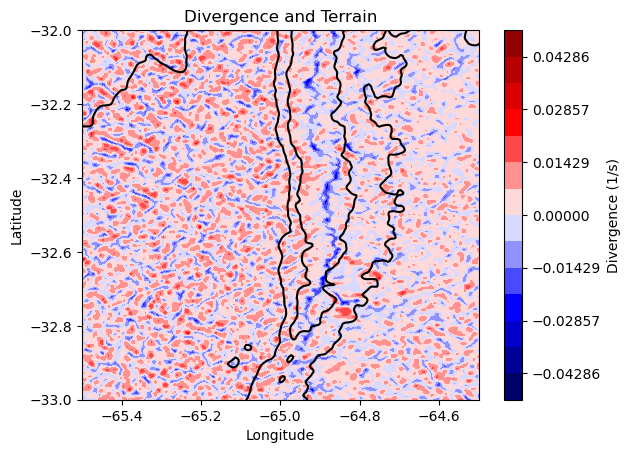

In [51]:
# Plot a single time step

cf = plt.contourf(ds.XLONG, ds.XLAT, ds['Divergence'].isel(Time=44), cmap='seismic', levels=np.linspace(-0.05,0.05,15))
plt.contour(ds.XLONG, ds.XLAT, ds.HGT[0,:,:], levels=[500, 1000, 1500], colors='k')
#plt.barbs(ds.XLONG[::40, ::40], ds.XLAT[::40, ::40], u[::40, ::40], v[::40, ::40])
plt.xlim(-65.5, -64.5)
plt.ylim(-33, -32)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Divergence and Terrain')
plt.colorbar(cf, label='Divergence (1/s)')

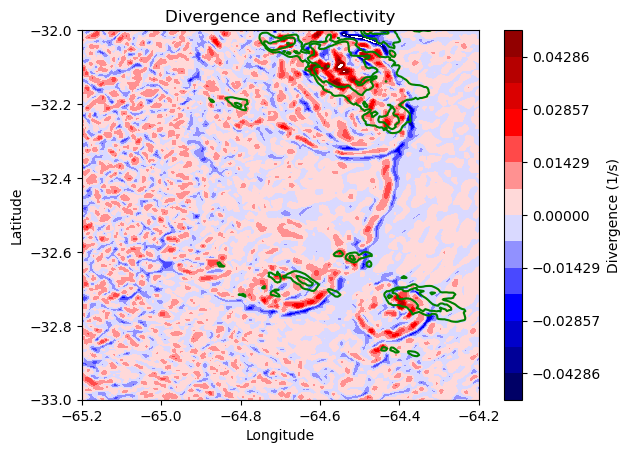

In [52]:
# Plot a single time step

cf = plt.contourf(ds.XLONG, ds.XLAT, ds['Divergence'].isel(Time=54), cmap='seismic', levels=np.linspace(-0.05,0.05,15))
plt.contour(ds.XLONG, ds.XLAT, ds.REFL_10CM_MAX[54,:,:], levels=[50, 60], colors='green')
#plt.barbs(ds.XLONG[::40, ::40], ds.XLAT[::40, ::40], u[::40, ::40], v[::40, ::40])
plt.xlim(-65.2, -64.2)
plt.ylim(-33, -32)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Divergence and Reflectivity')
plt.colorbar(cf, label='Divergence (1/s)')

So it appears that the terrain is playing a role in initiating convection with convergence along the ridge of the mountain range adding lift to initiate convection. Subsequently, outflow from the initial storms generates more convergence and lift to help initiate more convection.

In [61]:
ds.WA[44,10,:,:].max().compute()

<xarray.DataArray 'WA' ()> Size: 4B
array(4.2769575, dtype=float32)
Coordinates:
    Time     datetime64[ns] 8B 2019-01-29T17:00:00
    XTIME    float32 4B 660.0